This notebook is part of Andreu's (esdandreu@gmail.com) Master Thesis work at
Keio University.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/AcousticOdometry/AO/blob/main/notebooks/models.ipynb)


# Setup

This section will take care of installing the necessary packages as well as
configuring some environment variables.


## Colab

Assess wether the notebook is being executed in [Google
Colab](https://colab.research.google.com/) and if so, set up the software
needed in Colab runtime.


In [2]:
%%capture
try:
    from google import colab
    COLAB_RUNTIME = True
    %pip install torchinfo
    colab.drive.mount('/content/drive')
except ImportError:
    COLAB_RUNTIME = False

## Packages


In [3]:
import numpy as np
import pandas as pd

from pathlib import Path
from typing import Tuple

### AO

Setup Acoustic Odometry python package. If this notebook is being executed in
[Colab](#colab), the package will be installed from Github. Because of this, a
Github [personal access
token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
is needed for the installation.

If the notebook is not running on Colab and the package is not already
installed, installation instructions will be prompted.


In [4]:
if COLAB_RUNTIME:
    import subprocess
    import requests
    import sys
    import os
    #@markdown Use a [GitHub Personal Access Token](https://docs.github.com/en/authentication/keeping-your-account-and-data-secure/creating-a-personal-access-token)
    GITHUB_TOKEN = ''  #@param {type:"string"}
    auth = requests.auth.HTTPBasicAuth('', GITHUB_TOKEN)
    response = requests.get(
        "https://api.github.com/repos/AcousticOdometry/AO/releases/latest",
        auth=auth
        )
    try:
        response.raise_for_status()
    except requests.HTTPError as e:
        raise RuntimeError(
            'Check GITHUB_TOKEN is a Personal Access Token with repo access'
            )
    headers = {'Accept': 'application/octet-stream'}
    for asset in response.json()['assets']:
        r = requests.get(
            asset['url'], auth=auth, allow_redirects=True, headers=headers
            )
        r.raise_for_status()
        wheel_name = asset['name']
        with open(wheel_name, 'wb') as f:
            f.write(r.content)
        try:
            result = subprocess.check_output([
                sys.executable, '-m', 'pip', 'install', wheel_name
                ])
            print(f'Installed {wheel_name}')
            break
        except subprocess.CalledProcessError as e:
            pass
        finally:
            os.remove(wheel_name)
    import ao
else:
    try:
        import ao
    except ImportError:
        raise ImportError(
            "Acoustic Odometry python extension is not installed. Check "
            r"https://github.com/AcousticOdometry/AO#readme"
            " for detailed instructions."
            )

# Odometry

In [5]:
if COLAB_RUNTIME:
    # @markdown Check where is the experiment folder situated in your drive folder.
    # @markdown Remember that if you have been shared the folder, you can
    # @markdown [add a shortcut to your drive](https://support.google.com/drive/answer/9700156?hl=en&co=GENIE.Platform%3DDesktop)
    # @markdown in order to make it available in google colab.
    experiment = "/content/drive/MyDrive/VAO_WheelTestBed-Experiment-1"  #@param {type:"string"}
    EXPERIMENT_FOLDER = Path(experiment)
    if not EXPERIMENT_FOLDER.is_dir():
        raise RuntimeError(f'Invalid experiment folder {EXPERIMENT_FOLDER}')
else:
    EXPERIMENT_FOLDER = ao.dataset.utils.get_folder(
        env='WHEELTESTBED_EXPERIMENT2'
        )
VALIDATION_FOLDER = EXPERIMENT_FOLDER / 'validation-recordings'
MODELS_FOLDER = Path().parent.parent / 'models'

## Generate recording ground truth

In [6]:
recording = VALIDATION_FOLDER / 'date_2022-05-20;time_16-59-56'

def get_recording_bounds(recording: Path) -> Tuple[float, float]:
    start_timestamp = np.Inf
    end_timestamp = 0
    for wav_file in recording.glob('microphone*.wav'):
        config = ao.io.yaml_load(wav_file.with_suffix('.yaml'))
        start_timestamp = min(start_timestamp, config['start_timestamp'])
        end_timestamp = max(end_timestamp, config['end_timestamp'])
    return start_timestamp, end_timestamp

get_recording_bounds(recording=recording)

(1653033646.109341, 1653033821.222812)

,X,Vx,Vw,slip,wheel_rotation
timestamp,,,,,
1.653034e+09,0.00,0.0000,0.0000,0.00000,0.000000
1.653034e+09,0.00,0.0000,0.0000,0.00000,0.002397
1.653034e+09,0.11,0.0011,7.0113,0.91011,0.703520
1.653034e+09,1.29,0.0118,9.8078,0.31066,1.684300
1.653034e+09,3.71,0.0242,10.1710,-0.36320,2.701400


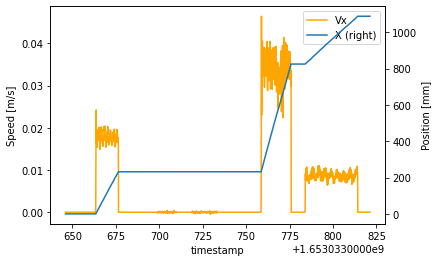

In [80]:
def get_recording_ground_truth(recording: Path) -> pd.DataFrame:
    ground_truth_path = recording / 'ground_truth.csv'
    if ground_truth_path.exists():
        return pd.read_csv(ground_truth_path, index_col='timestamp')
    start_timestamp, end_timestamp = get_recording_bounds(recording)
    gt = pd.DataFrame(columns=['X', 'Vx', 'Vw', 'slip', 'wheel_rotation'])
    gt.loc[start_timestamp] = np.zeros(len(gt.columns))
    for control_file in sorted(recording.glob('*.csv')):
        if control_file.stem == 'ground_truth':
            continue
        df = pd.read_csv(
            control_file,
            index_col='timestamp',
            usecols=['timestamp'] + list(gt.columns),
            parse_dates=True,
            )
        # Accumulable columns
        for col in ['X', 'wheel_rotation']:
            df[col] = df[col] + gt[col].iloc[-1]
        # Wheel stops at the end of the movement, assume stopped after 100 ms
        df.loc[df.tail(1).index.item() + 0.1] = df.iloc[-1].copy()
        # Update the first and last row with null velocities
        for col in ['Vx', 'Vw', 'slip']:
            col_index = gt.columns.get_loc(col)
            df.iloc[0, col_index] = 0
            df.iloc[-1, col_index] = 0
        # After each control the wheel stops
        gt = pd.concat([gt, df])
    gt.loc[end_timestamp] = gt.iloc[-1].copy()
    for col in ['Vx', 'Vw', 'slip']:
        col_index = gt.columns.get_loc(col)
        gt.iloc[-1, col_index] = 0
    gt.to_csv(ground_truth_path, index_label='timestamp')
    return gt


ground_truth = get_recording_ground_truth(recording=recording)
ax = ground_truth.plot(y=['Vx'], ylabel='Speed [m/s]', color='orange')
ground_truth.plot(ax=ax, y=['X'], secondary_y=True).set_ylabel('Position [mm]')
ground_truth.head()

## Apply model to recording

In [ ]:
# TODO apply model to recording and plot vs ground truth